In [1]:
import xarray as xr
import pandas as pd
import csv
import netCDF4
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse 
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler
import csv
import netCDF4
from scipy import stats

   

In [2]:
t = xr.open_dataset('04-tamsatMonthly.v3.1-410227200-1672531200_ken.nc', decode_coords="all")
t

<xarray.Dataset>
Dimensions:     (lat: 248, lon: 213, time: 480)
Coordinates:
  * lat         (lat) float32 4.613 4.575 4.537 4.5 ... -4.575 -4.613 -4.65
  * lon         (lon) float32 33.94 33.97 34.01 34.05 ... 41.81 41.85 41.89
  * time        (time) datetime64[ns] 1983-01-31 1983-02-28 ... 2022-12-31
Data variables:
    rfe         (time, lat, lon) float32 ...
    rfe_filled  (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    CreatedBy:    EDAL Libraries
    MoreInfo:     https://github.com/Reading-eScience-Centre/edal-java

In [3]:
def SUMMER(month):
        
    return (month >= 7) & (month <= 10)


lon_name   = t.lon[:]
lat_name   = t.lat[:]
    
seasonal_data_summer = t.sel(time=SUMMER(t['time.month']))
seasonal_data_summer1 = seasonal_data_summer.groupby('time.year').mean()



print("Reseized Area:",seasonal_data_summer1)
print("SUMMER SEASON MINIMUM RFE:", seasonal_data_summer1.rfe.min())
print("SUMMER SEASON MAXIMUM RFE:", seasonal_data_summer1.rfe.max())

#print ('saving to ', NCoutputSUMMER)

seasonal_data_summer1.to_netcdf('04-tamsatMonthly_summer.nc')
#return seasonal_data_summer1
print ('finished saving')

Reseized Area: <xarray.Dataset>
Dimensions:     (lat: 248, lon: 213, year: 40)
Coordinates:
  * lat         (lat) float32 4.613 4.575 4.537 4.5 ... -4.575 -4.613 -4.65
  * lon         (lon) float32 33.94 33.97 34.01 34.05 ... 41.81 41.85 41.89
  * year        (year) int64 1983 1984 1985 1986 1987 ... 2019 2020 2021 2022
Data variables:
    rfe         (year, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    rfe_filled  (year, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
SUMMER SEASON MINIMUM RFE: <xarray.DataArray 'rfe' ()>
array(0., dtype=float32)
SUMMER SEASON MAXIMUM RFE: <xarray.DataArray 'rfe' ()>
array(311.15, dtype=float32)
finished saving


In [4]:
lon_name = 'lon'
lat_name = 'lat'
fy_1D= t.mean(dim=(lat_name, lon_name), skipna=True)
fy_1D.to_dataframe()
#print ('saving to ', NcFile1Doutput)
fy_1D.to_netcdf('tamsat_ts.nc')
print ('finished saving') 
print("File Dimension:",fy_1D)

finished saving
File Dimension: <xarray.Dataset>
Dimensions:     (time: 480)
Coordinates:
  * time        (time) datetime64[ns] 1983-01-31 1983-02-28 ... 2022-12-31
Data variables:
    rfe         (time) float32 nan 27.85 27.37 78.39 ... 21.97 36.79 92.33 40.71
    rfe_filled  (time) float32 6.026 27.85 27.37 78.39 ... 36.79 92.33 40.71


In [5]:
#fy_1D.variables['time']

In [6]:
import netCDF4
import pandas as pd

rainfall_nc_file = 'tamsat_ts.nc'
nc = netCDF4.Dataset(rainfall_nc_file, mode='r')

nc.variables.keys()

time_var = nc.variables['time']
dtime = netCDF4.num2date(time_var[:],time_var.units)
rainfall = nc.variables['rfe'][:]

rainfall_ts = pd.Series(rainfall, index=dtime) 
headerList = ['DATE', 'RFE']

rainfall_ts.to_csv('tamsat_ts.csv',index=True, header=True)

In [7]:
import csv

  
file = pd.read_csv("tamsat_ts.csv")
#print("\nOriginal file:")
#print(file)
  
# adding header
headerList = ['DATE', 'RFE']
  
# converting data frame to csv
file.to_csv("tamsat_ts_final.csv", header=headerList, index=False)
  

In [8]:
ds = pd.read_csv("tamsat_ts_final.csv")
#data

In [9]:
  # assuming that date is the 1st column, value is the 2nd column
dateCol = 0
valCol = 1
  # converting object to date
ds.iloc[:,dateCol] = pd.to_datetime(ds.iloc[:,dateCol])

In [19]:
#ds = data.RFE.groupby('time.year').mean(dim='time')
valColName = ds.iloc[:,valCol].name
dsy = ds.groupby(ds.DATE.dt.year)[valColName].agg("mean")

In [11]:
vals = dsy.values
alpha = .95
medslope, medintercept, lo_slope, up_slope = stats.mstats.theilslopes(vals, alpha=alpha)

dsy_kk = np.arange(len(vals))
kendallTau, pvalue = stats.kendalltau(dsy_kk, vals)


print("dsy_kk:",dsy_kk)
print("Med slope:", medslope)
print("Med Intercept:", medintercept)
print("lo slope:", lo_slope)
print("Up slope:", up_slope)
print("p_value:", pvalue)
#return medslope, medintercept, lo_slope, up_slope, pvalue

dsy_kk: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Med slope: 0.2947989657986112
Med Intercept: 37.66381903056345
lo slope: 0.04118688235294097
Up slope: 0.6156747149122808
p_value: 0.030227807155613382


In [12]:
inputDs = xr.open_dataset('04-tamsatMonthly_summer.nc')




def _compSenSlope(vals):
    alpha = .95
    medslope, _, _, _ = stats.mstats.theilslopes(vals, alpha=alpha)
    return medslope


slp = xr.apply_ufunc(_compSenSlope, inputDs, input_core_dims=[["year"]], dask="allowed", vectorize=True)




slp.to_netcdf('04-tamsatMonthly_summer_senSlope.nc')
print("Output:", slp)
print("output  min:", slp.rfe.min())
print("output max:", slp.rfe.max())
#return slp

Output: <xarray.Dataset>
Dimensions:     (lat: 248, lon: 213)
Coordinates:
  * lat         (lat) float32 4.613 4.575 4.537 4.5 ... -4.575 -4.613 -4.65
  * lon         (lon) float32 33.94 33.97 34.01 34.05 ... 41.81 41.85 41.89
Data variables:
    rfe         (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    rfe_filled  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
output  min: <xarray.DataArray 'rfe' ()>
array(-0.17755839)
output max: <xarray.DataArray 'rfe' ()>
array(2.25236357)


In [13]:
slp_10=slp*36
slp_10
slp_10.to_netcdf('04-tamsatMonthly_summer_senSlope_36.nc')


In [14]:
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline
import seaborn as sns
import rasterio
import rasterio.plot
from rasterio.plot import show
import fiona
import rasterio.mask
from matplotlib import rcParams
import matplotlib.pyplot as plt
from pyproj import Transformer
import numpy as np
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [15]:
import rioxarray

# Load image and visualize
#data = xr.open_dataset('04-tamsatMonthly_summer_senSlope.nc', decode_coords="all")
data = xr.open_dataset('04-tamsatMonthly_summer_senSlope_36.nc', decode_coords="all")

#raster.plot.imshow(figsize=(8,8))
data

<xarray.Dataset>
Dimensions:     (lat: 248, lon: 213)
Coordinates:
  * lat         (lat) float32 4.613 4.575 4.537 4.5 ... -4.575 -4.613 -4.65
  * lon         (lon) float32 33.94 33.97 34.01 34.05 ... 41.81 41.85 41.89
Data variables:
    rfe         (lat, lon) float64 ...
    rfe_filled  (lat, lon) float64 ...

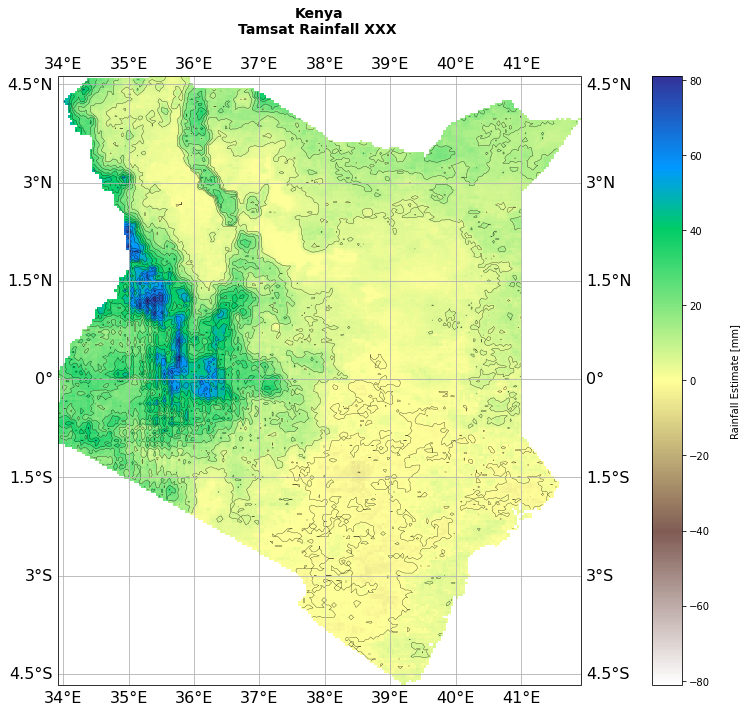

In [16]:
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(projection=ccrs.PlateCarree())

heatmap=data.rfe.plot(
    ax=ax,
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    cmap="terrain_r",
    shading="auto",
    add_colorbar=False,
    #vmin=data.rfe.min(),
    #vmax=data.rfe.max()
)
lines=data.rfe.plot.contour(ax=ax,alpha=1,linewidths=0.3,colors = 'k',linestyles='None',levels=30)

g1 = ax.gridlines(draw_labels = True)
g1.xlabel_style = {'size': 16, 'color': 'k'}
g1.ylabel_style = {'size': 16, 'color': 'k'}
#add embellishment

plt.title("Kenya\nTamsat Rainfall XXX \n",fontweight='bold', size=14)
cbar = plt.colorbar(heatmap)
cbar.ax.set_ylabel('Rainfall Estimate [mm]',labelpad=+20, rotation=90)
plt.tight_layout()
#plt.savefig('Tamsat_Rainfall_Monthly_Mean.png')
plt.show()